In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, model_selection, preprocessing

import datetime
from itertools import product
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/home/frodos/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
def regression(res, alpha = 0.1, plot = False,verbose = False, searchBestFit = False):
    X = res.drop('trip_count',axis = 1)        
    y = res.loc[:,'trip_count'];
    
    if searchBestFit:
        # создать словарь параметров
        param_grid = {'alpha': [x for x in np.linspace(10,500,20)]} #,'l1_ratio': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1]}
        # создать кросс-валидацию для временных рядов
        tscv = model_selection.TimeSeriesSplit()
        
        # запустить поиск оптимальных параметров
        regressor = linear_model.Ridge()
        clf = model_selection.GridSearchCV(regressor, param_grid, n_jobs=4, cv=tscv, verbose=1)
        clf.fit(X,y)
        regressor = clf.best_estimator_        
        print 'Best params is', clf.best_params_ 
        
        
    else:
        regressor = linear_model.Lasso(alpha = alpha, max_iter = 1e5,fit_intercept = True,random_state = 0);
        regressor.fit(X,y)
        
    y_pr = pd.Series(data = regressor.predict(X), index = res.index)
    R = regressor.score(X,y);
    print 'R factor is ', R
    
    if plot:
        plt.figure(figsize = [15,10])
        plt.subplot(211)
        plt.plot(y)
        plt.plot(y_pr)
        plt.legend(['Original data','Predicted'])

        plt.subplot(212)
        plt.plot(y-y_pr)
        plt.legend(['Residuals'])
        
    return [y_pr, y-y_pr, regressor]

In [3]:
def getRegressor(regressor, start_date = '2016-05-15 00:00:00', end_date = '2016-05-20 23:00:00'):
    predictionStart = datetime.datetime.strptime(start_date,'%Y-%m-%d %H:%M:%S')
    predictionEnd = datetime.datetime.strptime(end_date,'%Y-%m-%d %H:%M:%S')
    date_index = pd.date_range(predictionStart, predictionEnd, freq='H')
   
    #какой-то пипец. Должен быть способ сделать это проще.
    features = date_index.to_series().to_frame()
    features = addFeatures(features,verbose = True)
    features = features.drop(0,axis = 1)
    exog = regressor.predict(features)
    return pd.Series(exog,index = date_index)

In [4]:
def addFeatures(res, Kw = 6, Ka = 3,verbose = False):    
    # add linear feature
    res = res.assign(hours = (res.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(res.index.dayofweek),columns = ['DayOfWeek_'+str(x) for x in np.arange(6)],
                       index = res.index)      
    res = res.merge(DoW,left_index=True,right_index=True)
 
    # добавляем dummy variables для месяца
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(res.index.month),columns = ['Month_'+str(x) for x in np.arange(12)],index = res.index)      
    res = res.merge(Months,left_index=True,right_index=True);
    return res

In [ ]:
def findHyperParams(ts,pList = []):
    
    if (len(pList) ==0):
        # create list of parameters
        ps = range(2, 7)
        d  = 1
        qs = range(2, 7)

        Ps = range(1, 3)
        D  = 1
        Qs = range(1, 3)

        pList = list(product(ps, qs, Ps, Qs))
    
    results = []
    best_aic = float("inf")
    
    # add features
    ts = addFeatures(ts, Kw = 6, Ka = 3)
    # regression
    [s, r, lasso] = regression(ts,verbose = True, searchBestFit = True)
    
    # loop over parameters' list
    for param in pList:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        print('Parameters:', param)
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(ts.loc[:,'trip_count'], order=[param[0], 1, param[1]],
                                          seasonal_order=(param[2], 1, param[3], 24),exog = r).fit(disp=1);
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except Exception as inst:
            print inst           # __str__ allows args to be printed directly
            continue
        else:     
            aic = mSARIMA.aic
            print('AIC',aic) 
            #сохраняем лучшую модель, aic, параметры
            if aic < best_aic:
                best_model = mSARIMA
                best_aic = aic
                best_param = param
            results.append([param, mSARIMA.aic])
    return [best_aic,best_param, best_model]

In [6]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
df.columns = regsDf.regId.values.astype('str')

# словарь с группировкой рядов
tsGroups = np.load('tsGroups.npy').item()

# словарь с оптимальными параметрами для каждой группы
paramsGroups = np.load('paramsGroups.npy').item()

*Логика скрипта:*
<ol>
<li> Выбираем одну группу
<li> В группе выбираем один ряд
<li> По номеру группы подгружаем оптимальные параметры
<li> Обучаем регрессор
<li> Обучаем SARIMAX модель
<li> Сохраняем модель (??? Может быть без данных, чтобы сэкономить место).
<li> Делаем предсказание
<li> Сохраняем предсказение
<li> Идём на второй или первый шаг
<ol>
    

In [ ]:
# выберу настроечные ряды руками
fitSeries = {'gr18':'1274','gr19':'1684','gr10':'1333','gr11':'1075','gr12':'2118','gr13':'1387','gr14':'1384','gr15':'1174'}
fitSeries.update({'gr16':'1483','gr17':'1282','gr21':'1184','gr20':'1131','gr23':'1332','gr22':'1580','gr6':'1177','gr7':'1388'})
fitSeries.update({'gr4':'1128','gr2':'1234','gr3':'1231','gr0':'1286','gr1':'1125','gr8':'1181','gr9':'1532'})

In [ ]:
def saveResults(df, fName):
    """
    Save dataframe df to file fName
    """
    f = open(fName, 'w')
    for ts in df.index.levels[0]:
        for lag in df.index.levels[1][6:-5]:
            for i in np.arange(6):
                try:
                    historyStart = lag - datetime.timedelta(hours = 1)
                    res = df.loc[ts,lag].y[i]
                    if res<0:
                        res = 0
                    s =  str(ts)+'_'+datetime.datetime.strftime(historyStart, "%Y-%m-%d") +'_'+ str(historyStart.hour)+'_'+str(i+1)+','+str(res)+'\n'
                except Exception as ins:
                    print lag, ts, i
                    print ins
                else:
                    f.write(s)

    f.close()

In [7]:
# диапазон дат для обучения
startFit = '2015-01-01 0:0:0'
endFit = '2016-05-31 23:00:00'

err = 0

# диапазон дат для предсказания
startPrediction = '2016-05-31 18:00:00'
endPrediction   = '2016-06-30 23:00:00'
predictionRange = pd.date_range(startPrediction, endPrediction, freq='H')

# словарь с оптимальными параметрами для каждой группы
#paramsGroups = np.load('paramsGroups.npy').item()

# create array to save prediction results
mIndex = pd.MultiIndex.from_product([df.columns.values, predictionRange])
resDf = pd.DataFrame(index = mIndex, columns = ['y','err'])
# load data

# тестирую ряд 1075, gr11

grId = 'gr11'
tsId = '1075'   

params = paramsGroups.get(grId)[1]

In [23]:
# получаем параметры SARIMAX модели
params = paramsGroups.get(grId)[1] 

print 'Regions is ', tsId
# получаем временной ряд
ts = df.loc[startFit:endFit,tsId] #

# обучаем регрессор
ts = ts.to_frame(name = 'trip_count')

#[best_aic,best_params, best_model] = findHyperParams(ts)
#print best_params
#params = best_params

[r_pr, res, regressor] = regression(addFeatures(ts), verbose = True, searchBestFit = True)
exog = getRegressor(regressor,startFit,endFit)

Regions is  1075
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params is {'alpha': 164.73684210526318}
R factor is  0.056635952918


[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    0.8s finished


(394464, 395208)

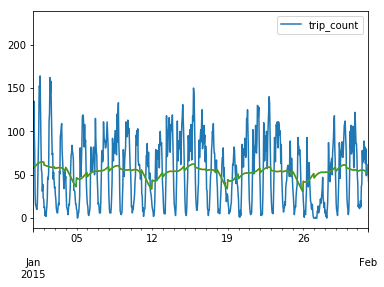

In [24]:
ts.plot()
r_pr.plot()
exog.plot()
plt.xlim(['01-01-2015','02-01-2015'])

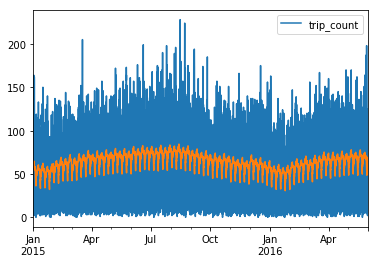

In [25]:
ts.plot()
exog.plot()

In [26]:
# обучаем SARIMAX модель
print 'Teach SARIMAX'
try:
    mSARIMA=sm.tsa.statespace.SARIMAX(ts, order=[params[0], 2, params[1]],
                                      seasonal_order=(params[2], 1, params[3], 24),
                                      exog = exog).fit(disp=1);

    # получаем предсказания регрессора на весь диапазон дат (обучение+предсказание)
    exog = getRegressor(regressor,startFit,endPrediction)
    # получаем данные о поездкахы на весь диапазон дат
    endog = df.loc[startFit:endPrediction,tsId]

    # создаём новую модель, которую будет использовать для предсказания
    model_fitted = sm.tsa.statespace.SARIMAX(endog, order=[params[0], 2, params[1]],
                                         seasonal_order=(params[2], 1, params[3], 24),
                                         exog = exog).filter(mSARIMA.params)
except Exception as inst:
    print 'Can not teach or create the model'
    print inst

Teach SARIMAX


In [11]:
# проходим по всему диапазону дат предсказаний
print 'Make prediction'
for firstLag in predictionRange:
    lastLag = firstLag+datetime.timedelta(hours = 5)
    # prediction
    try:
        predicted_data = model_fitted.predict(firstLag, lastLag, dynamic=True, exog = exog[firstLag:lastLag])
    except Exception as inst:
        print 'Prediction error'
        print inst
    else:
        # save results
        resDf.loc[tsId,firstLag].y = predicted_data
        err += (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().sum()
        resDf.loc[tsId,firstLag].err = (df.loc[startPrediction:endPrediction,tsId]-predicted_data).abs().mean()

Make prediction
Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction error

Prediction e

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/frodos/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/frodos/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/frodos/anaconda/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/frodos/anaconda/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/frodos/anaconda/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/frodos/anaconda/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/hom

IndexError: string index out of range

In [13]:
firstLag

Timestamp('2016-06-08 00:00:00', freq='H')

In [ ]:
model_fitted.predict(firstLag, lastLag, dynamic=True, exog = exog[firstLag:lastLag])